In [1]:
import sys
sys.path.append("..")

from system_controller import SystemController, ControlNoiseInit
from utils import transform_angle_error, transform_02pi_to_negpospi, Simulator, ParametricPath, Trajectory
from neural_networks.dynamics_networks import TransferNN

import numpy as np
import time
import matplotlib.pyplot as plt
from time import perf_counter
import os
from pathlib import Path

plt.style.use(["science", "vibrant"])

In [2]:
import tensorflow as tf

# Pendulum
Try MPPI controller with neural network dynamics model on an inverted pendulum.

### Controller Definition

In [4]:
# Get neural network model loaded
pend_model_path = Path(os.getcwd()).parent / "neural_networks" / "pendulum" / "models"
pend_availible_models = [x for x in pend_model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(pend_availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
pend_nn_model = tf.keras.models.load_model(pend_availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/inverted_pendulum_model_16nodes_18-04-2023 04:50:54
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_rollouts__24-04-2023 23:00:02
[2]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/inverted_pendulum_model_16nodes_20-04-2023 02:54:16
[3]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_rollouts__23-04-2023 02:48:16
[4]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_tanh_32_rollouts__26-04-2023 02:34:02
[5]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_model_16nodes_rollouts
[6]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_tanh_32_rollouts__26-04-2023 02:29:47
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [20]:
from systems.dynamical_systems import Pendulum

# Define the cartpole system parameters
pend = Pendulum(m=1, l=1, b=0.1, dt=1 / 10)

# Define the controller cost functions
DESIRED_THETA = np.pi
DESIRED_OMEGA = 0.0

def terminal_cost(x):
    theta, omega = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    omega_error = DESIRED_OMEGA - omega

    error = np.array([theta_error, omega_error])
    Q = np.diag([1e3, 1e2])

    return error.T @ Q @ error


def state_cost(x):
    theta, omega = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1

    error = np.array([theta_error])
    Q = np.diag([1e3])

    return error.T @ Q @ error

# Define the neural network and ground truth controllers
DS=pend
N_ROLLOUTS=100
HORIZON_LENGTH=10
EXPLORATION_COV=np.diag([2.0 ** 2])
EXPLORATION_LAMBDA=1e1
ALPHA_MU=0.1
ALPHA_SIGMA=0.98
STATE_COST=state_cost
TERMINAL_COST=terminal_cost
CONTROL_RANGE={"min": pend.u_lo, "max": pend.u_hi}
CONTROL_NOISE_INITIALIZATION=ControlNoiseInit.ZERO

nn_pend_controller = SystemController(
    ds=DS,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    state_cost=STATE_COST,
    terminal_cost=TERMINAL_COST,
    control_range=CONTROL_RANGE,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
    nn_model=pend_nn_model
)

gt_pend_controller = SystemController(
    ds=DS,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    state_cost=STATE_COST,
    terminal_cost=TERMINAL_COST,
    control_range=CONTROL_RANGE,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION
)

## Pendulum Swing Up Task
Test the MPPI controller on a swing-up task using the neural network dynamics model for rollouts.

### Simulation Definition

In [21]:
PEND_INITIAL_STATE = np.array([np.radians(0), 0])
PEND_SIMULATION_LENGTH = 12

In [22]:
nn_pend_env = Simulator(pend, controller=nn_pend_controller)
nn_pend_states, nn_pend_controls, pend_time = nn_pend_env.run(simulation_length=PEND_SIMULATION_LENGTH, initial_state=PEND_INITIAL_STATE,
                                               controlled=True, timing=True)

gt_pend_env = Simulator(pend, controller=gt_pend_controller)
gt_pend_states, gt_pend_controls, pend_time = gt_pend_env.run(simulation_length=PEND_SIMULATION_LENGTH, initial_state=PEND_INITIAL_STATE,
                                               controlled=True, timing=True)

> Step controller:
  Rollouts -- mean: 0.010000000000000002, var: 0.009899999999990087, min: 2.4938719758500797e-30, max: 0.9999999999995044

> Step controller:
  Rollouts -- mean: 0.009999999999999998, var: 0.009785339123641093, min: 3.4109291365989577e-54, max: 0.994233706040645

> Step controller:
  Rollouts -- mean: 0.01, var: 0.009707661156940675, min: 2.4397153718120413e-80, max: 0.9902887611948239

> Step controller:
  Rollouts -- mean: 0.01, var: 0.007522747299367638, min: 1.9816045856488367e-60, max: 0.8646129346271467

> Step controller:
  Rollouts -- mean: 0.010000000000000002, var: 0.0028482421011852303, min: 2.4099586482040296e-63, max: 0.45292077175966394

> Step controller:
  Rollouts -- mean: 0.009999999999999997, var: 0.0042509100627160555, min: 6.441677296461156e-50, max: 0.48286787737886033

> Step controller:
  Rollouts -- mean: 0.010000000000000002, var: 0.002475630520837998, min: 1.1012728722219839e-55, max: 0.46060242365369924

> Step controller:
  Rollouts -- me

### Simulation Results

/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_32492/2232531521.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


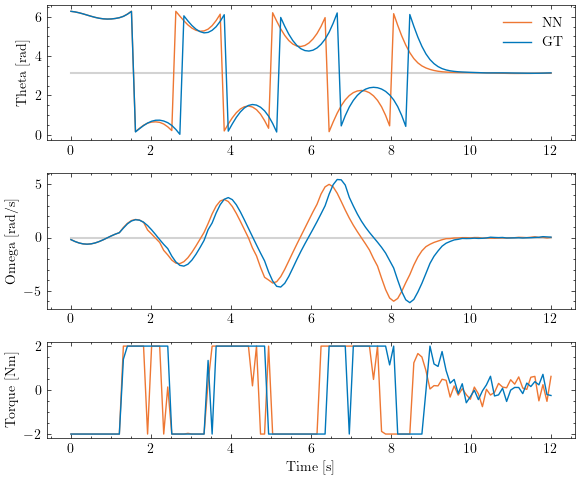

In [23]:
# Plot the results
fig, axd = plt.subplot_mosaic([['theta'],
                               ['omega'],
                               ['tau']], figsize=(6, 5), layout="constrained",
                               gridspec_kw={'height_ratios': [0.7, 0.7, 0.5]})

axd['theta'].plot(pend_time, [DESIRED_THETA]*len(pend_time),
                  linewidth=1.5, color="lightgrey")
axd['theta'].plot(pend_time, nn_pend_states[:, 0], linewidth=1, label="NN")
axd['theta'].plot(pend_time, gt_pend_states[:, 0], linewidth=1, label="GT")
axd['theta'].set(ylabel="Theta [rad]")
axd['theta'].legend(loc="upper right")

axd['omega'].plot(pend_time, [DESIRED_OMEGA]*len(pend_time),
                  linewidth=1.5, color="lightgrey")
axd['omega'].plot(pend_time, nn_pend_states[:, 1], linewidth=1, label="NN")
axd['omega'].plot(pend_time, gt_pend_states[:, 1], linewidth=1)
axd['omega'].set(ylabel="Omega [rad/s]")

axd['tau'].plot(pend_time, nn_pend_controls[:, 0], linewidth=1, label="NN")
axd['tau'].plot(pend_time, gt_pend_controls[:, 0], linewidth=1)
axd['tau'].set(ylabel="Torque [Nm]")

plt.xlabel("Time [s]")
plt.tight_layout()
fig.savefig("figs/nn_vs_gt_pendulum_swingup.png")

# Cart-Pole
Try MPPI controller with a cart-pole system

### Controller Definition

In [39]:
# Get neural network model loaded
cartpole_model_path = Path(os.getcwd()).parent / "neural_networks" / "cartpole" / "models"
cartpole_availible_models = [x for x in cartpole_model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(cartpole_availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
cartpole_nn_model = tf.keras.models.load_model(cartpole_availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/cartpole/models/cartpole_rollouts_64__26-04-2023 01:00:47
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/cartpole/models/cartpole_tanh_rollouts_64__26-04-2023 02:01:22


In [40]:
from systems.dynamical_systems import CartPole

# Define the cartpole system parameters
cartpole = CartPole(m_pole=1, m_cart=1, l=1, dt=1 / 10)

# Define the controller cost functions
DESIRED_THETA = np.pi
DESIRED_CARTVEL = 0.0
DESIRED_CARTPOS = 0.0

def terminal_cost(x):
    pos, posdot, theta, thetadot = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    vel_error = DESIRED_CARTVEL - posdot
    pos_error = DESIRED_CARTPOS - pos

    error = np.array([theta_error, vel_error, pos_error])
    Q = np.diag([5e4, 1e2, 5e3])

    return error.T @ Q @ error

def state_cost(x):
    return terminal_cost(x)

# Define the neural network and ground truth controllers
DS=cartpole
N_ROLLOUTS=200
HORIZON_LENGTH=10
EXPLORATION_COV=np.diag([10.0 ** 2])
EXPLORATION_LAMBDA=2e3
ALPHA_MU=0.1
ALPHA_SIGMA=0.95
TERMINAL_COST=terminal_cost
STATE_COST=state_cost
CONTROL_RANGE={"min": cartpole.u_lo, "max": cartpole.u_hi}
CONTROL_NOISE_INITIALIZATION=ControlNoiseInit.ZERO

nn_cartpole_controller = SystemController(
    ds=DS,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
    nn_model=cartpole_nn_model
)

gt_cartpole_controller = SystemController(
    ds=DS,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION
)

## Cart Pole Swing Up Task
Test the MPPI controller on a cartpole swing-up task using the neural network dynamics model for rollouts.

### Simulation Definition

In [41]:
CARTPOLE_INITIAL_STATE = np.array([0.0, 0.0, np.radians(0.0), 0.0])
CARTPOLE_SIMULATION_LENGTH = 8

nn_cartpole_env = Simulator(cartpole, controller=nn_cartpole_controller)
nn_cartpole_states, nn_cartpole_controls, cartpole_time = nn_cartpole_env.run(simulation_length=CARTPOLE_SIMULATION_LENGTH, initial_state=CARTPOLE_INITIAL_STATE,
                                                   controlled=True, timing=True)

gt_cartpole_env = Simulator(cartpole, controller=gt_cartpole_controller)
gt_cartpole_states, gt_cartpole_controls, cartpole_time = gt_cartpole_env.run(simulation_length=CARTPOLE_SIMULATION_LENGTH, initial_state=CARTPOLE_INITIAL_STATE,
                                                   controlled=True, timing=True)

[Simulator] [Info] cart_pole simulation elapsed time: 5.58003 s
[Simulator] [Info] cart_pole simulation elapsed time: 6.46530 s


### Simulation Results

/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_30817/33666467.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


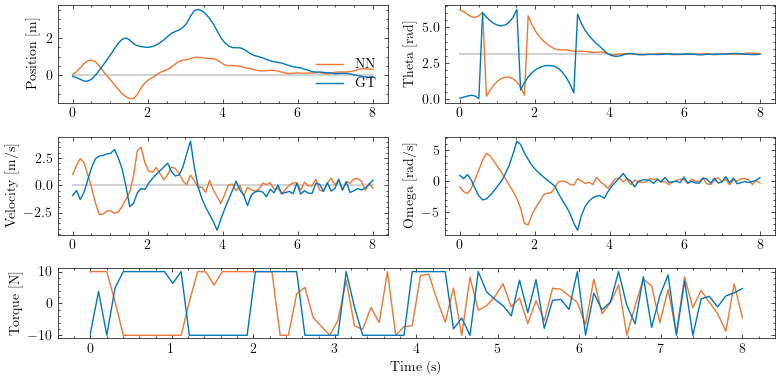

In [42]:
# Plot the results
fig, axd = plt.subplot_mosaic([['pos', 'theta'],
                               ['vel', 'omega'],
                               ['tau', 'tau']], figsize=(8, 4), layout="constrained",
                               gridspec_kw={'height_ratios': [0.7, 0.7, 0.5]})

axd['pos'].plot(cartpole_time, [DESIRED_CARTPOS]*len(cartpole_time),
                linewidth=1.5, color="lightgrey")
axd['pos'].plot(cartpole_time, nn_cartpole_states[:, 0], linewidth=1, label="NN")
axd['pos'].plot(cartpole_time, gt_cartpole_states[:, 0], linewidth=1, label="GT")
axd['pos'].set(ylabel="Position [m]")
axd['pos'].legend(loc="lower right")

axd['vel'].plot(cartpole_time, [DESIRED_CARTVEL]*len(cartpole_time),
                linewidth=1.5, color="lightgrey")
axd['vel'].plot(cartpole_time, nn_cartpole_states[:, 1], linewidth=1, label="NN")
axd['vel'].plot(cartpole_time, gt_cartpole_states[:, 1], linewidth=1, label="GT")
axd['vel'].set(ylabel="Velocity [m/s]")

axd['theta'].plot(cartpole_time, [DESIRED_THETA]*len(cartpole_time),
                  linewidth=1.5, color="lightgrey")
axd['theta'].plot(cartpole_time, nn_cartpole_states[:, 2], linewidth=1, label="NN")
axd['theta'].plot(cartpole_time, gt_cartpole_states[:, 2], linewidth=1)
axd['theta'].set(ylabel="Theta [rad]")

axd['omega'].plot(cartpole_time, nn_cartpole_states[:, 3], linewidth=1, label="NN")
axd['omega'].plot(cartpole_time, gt_cartpole_states[:, 3], linewidth=1)
axd['omega'].set(ylabel="Omega [rad/s]")


axd['tau'].plot(cartpole_time, nn_cartpole_controls[:, 0], linewidth=1, label="NN")
axd['tau'].plot(cartpole_time, gt_cartpole_controls[:, 0], linewidth=1)
axd['tau'].set(ylabel="Torque [N]")

plt.xlabel("Time (s)")
plt.tight_layout()

fig.savefig("figs/gt_vs_nn_cartpole_swingup.png")

# Planar 2R Dynamic Arm
Try MPPI controller with a planar two-link robot arm modeled with its EOMs.

### Controller Definition

In [43]:
# Get neural network model loaded
arm_model_path = Path(os.getcwd()).parent / "neural_networks" / "arm" / "models"
arm_availible_models = [x for x in arm_model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(arm_availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
arm_nn_model = tf.keras.models.load_model(arm_availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/arm/models/arm_tanh_rollouts_128__01-05-2023 05:01:49
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/arm/models/arm_tanh_rollouts_128__01-05-2023 04:55:43
[2]  /Users/micahreich/Documents/16711-final-project/neural_networks/arm/models/arm_tanh_rollouts_128__01-05-2023 05:07:08
[3]  /Users/micahreich/Documents/16711-final-project/neural_networks/arm/models/arm_tanh_rollouts_128_neg4to4__01-05-2023 05:16:43


In [44]:
def line(t):
    L=1.5
    return np.array([L*(1-t) + 2 - L, 0.0])

def semicircle(t):
    R = 2
    return np.array([R*np.cos(np.pi*t)+(2-R), R*np.sin(np.pi*t)])

def circle(t):
    R, tau = 0.8, 2*np.pi
    return np.array([R*np.cos(tau*t)+(2-R), R*np.sin(tau*t)])

def infty(t):
    R, tau = 2, 2*np.pi
    return np.array([R*np.cos(tau*t), R*np.sin(tau*t)*np.cos(tau*t)])

path = ParametricPath(parametric_eqn=infty, time_length=8)

In [8]:
from systems.dynamical_systems import Planar2RArm, FK2R, IK2R

# Define the cartpole system parameters
M1 = M2 = 1
L1 = L2 = 1
R1 = R2 = L1 / 2
I1 = I2 = 1/3 * M1 * L1**2

arm = Planar2RArm(
    m1=M1, m2=M2, l1=L1, l2=L2, r1=R1, r2=R2, I1=I1, I2=I2, dt=1/20
)

ik = IK2R(arm)

ARM_ACCEL_STDDEV = 3.0

# Define the controller cost functions
def terminal_cost(path):
    def tc(x):
        t1, dot_t1, t2, dot_t2, param, _ = x
        DESIRED_POSITION = path(param)
    
        pose = arm.fk(t1, t2)
        pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])

        error = np.array([pos_error, dot_t1, dot_t2])
        Q = np.diag([5e2, 5e2, 5e1])

        return np.dot(error, np.dot(Q, error)).astype(np.float64)
    return tc

def state_cost(path):
    def sc(x):
        t1, dot_t1, t2, dot_t2, param, _ = x
        DESIRED_POSITION = path(param)

        pose = arm.fk(t1, t2)
        pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])

        error = np.array([pos_error])
        Q = np.diag([5e3])

        return np.dot(error, np.dot(Q, error)).astype(np.float64)
    return sc

# Define the neural network and ground truth controllers
DS=arm
INVERSE_DYN_CONTROL=True
N_ROLLOUTS=150
HORIZON_LENGTH=30
EXPLORATION_COV=np.diag([ARM_ACCEL_STDDEV ** 2, ARM_ACCEL_STDDEV ** 2])
EXPLORATION_LAMBDA=1e2
ALPHA_MU=0.2
ALPHA_SIGMA=0.99
TERMINAL_COST=terminal_cost(path)
STATE_COST=state_cost(path)
CONTROL_RANGE={"min": arm.u_lo, "max": arm.u_hi}
INCLUDE_NULL_CONTROLS=False
CONTROL_NOISE_INITIALIZATION=ControlNoiseInit.ZERO

nn_arm_controller = SystemController(
    ds=DS,
    inverse_dyn_control=INVERSE_DYN_CONTROL,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    include_null_controls=INCLUDE_NULL_CONTROLS,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
    nn_model=arm_nn_model
)

gt_arm_controller = SystemController(
    ds=DS,
    inverse_dyn_control=INVERSE_DYN_CONTROL,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    include_null_controls=INCLUDE_NULL_CONTROLS,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
)

### Simulation Definition

In [46]:
ARM_T1_0, ARM_T2_0 = ik.solve(np.array([2, 0, 0])) + np.array([np.pi/2, 0])
ARM_INITIAL_STATE = np.array([ARM_T1_0, 0, ARM_T2_0, 0, 0, 1], dtype=np.float64)
ARM_SIMULATION_LENGTH = 9

nn_arm_env = Simulator(arm, controller=nn_arm_controller)
nn_arm_states, nn_arm_controls, arm_time = nn_arm_env.run(simulation_length=ARM_SIMULATION_LENGTH, initial_state=ARM_INITIAL_STATE,
                                               controlled=True, timing=True)

gt_arm_env = Simulator(arm, controller=gt_arm_controller)
gt_arm_states, gt_arm_controls, arm_time = gt_arm_env.run(simulation_length=ARM_SIMULATION_LENGTH, initial_state=ARM_INITIAL_STATE,
                                               controlled=True, timing=True)

[Simulator] [Info] planar_2r_arm simulation elapsed time: 13.40088 s
[Simulator] [Info] planar_2r_arm simulation elapsed time: 13.37246 s


/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_30817/2377413802.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Mean Position Error: 68.3189 mm


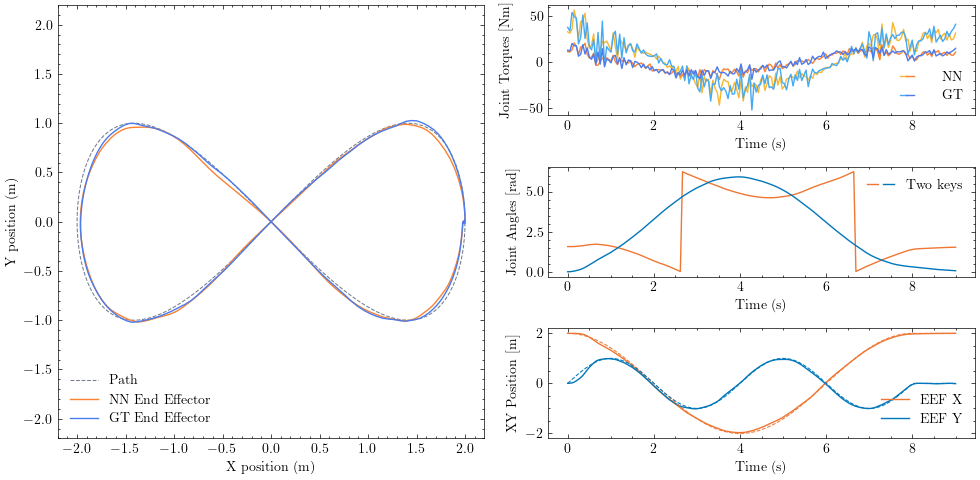

In [51]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

# Define helper functions to get some data on path tracking success
def mean_position_error(eef_positions, path_positions):
    return np.mean(
        np.linalg.norm(eef_positions - path_positions, axis=1)
    )

# Plot the results
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8.5), gridspec_kw={'height_ratios': [2.3, 1]})
fig, axd = plt.subplot_mosaic([['p', 't'], ['p', 'ja'], ['p', 'xy']], figsize=(10, 5), layout="constrained")

fk_v = np.vectorize(arm.fk, signature="(),()->(3)")

nn_eef_positions = fk_v(nn_arm_states[:, 0], nn_arm_states[:, 2])
gt_eef_positions = fk_v(gt_arm_states[:, 0], gt_arm_states[:, 2])

path_positions = path.get_points(arm_time)

# Plot end effector XY positions on large canvas
axd['p'].plot(path_positions[:, 0], path_positions[:, 1], label="Path",
              ls="--", linewidth=0.75, color="#747d8c")

axd['p'].plot(nn_eef_positions[:, 0], nn_eef_positions[:, 1], label="NN End Effector", color="#fa8231")
axd['p'].plot(gt_eef_positions[:, 0], gt_eef_positions[:, 1], label="GT End Effector", color="#4b7bec")

axd['p'].set(ylabel="Y position (m)", xlabel="X position (m)", ylim=(-2.2, 2.2), xlim=(-2.2, 2.2))
axd['p'].legend(loc="lower left")

# Plot joint torques
j1t_nn, = axd['t'].plot(arm_time, nn_arm_controls[:, 0], color="#f7b731")
j2t_nn, = axd['t'].plot(arm_time, nn_arm_controls[:, 1], color="#fa8231")

j1t_gt, = axd['t'].plot(arm_time, gt_arm_controls[:, 0], color="#45aaf2")
j2t_gt, = axd['t'].plot(arm_time, gt_arm_controls[:, 1], color="#4b7bec")

axd['t'].set(xlabel="Time (s)", ylabel="Joint Torques [Nm]")
axd['t'].legend([(j1t_nn, j2t_nn), (j1t_gt, j2t_gt)], ['NN', 'GT'],
                numpoints=2, handler_map={tuple: HandlerTuple(ndivide=5)})

# Plot joint angles
j1, = axd['ja'].plot(arm_time, nn_arm_states[:, 0])
j2, = axd['ja'].plot(arm_time, nn_arm_states[:, 2])
axd['ja'].set(xlabel="Time (s)", ylabel="Joint Angles [rad]")
axd['ja'].legend([(j1, j2)], ['Two keys'], numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)})

# Plot end effector positions
p = axd['xy'].plot(arm_time, nn_eef_positions[:, 0], label="EEF X")
q = axd['xy'].plot(arm_time, nn_eef_positions[:, 1], label="EEF Y")
axd['xy'].plot(arm_time, path_positions[:, 0],
               ls="--", linewidth=0.75, color=p[0].get_color())
axd['xy'].plot(arm_time, path_positions[:, 1],
               ls="--", linewidth=0.75, color=q[0].get_color())

axd['xy'].set(xlabel="Time (s)", ylabel="XY Position [m]")
axd['xy'].legend(loc="lower right")

plt.tight_layout()
fig.savefig("figs/arm_traj_follow.png")

print("Mean Position Error: {:.4f} mm".format(1e3 * mean_position_error(nn_eef_positions[:, :2], path_positions)))

# NN vs. GT Cost Comparison
Compare mean trajectory costs between neural network controllers and ground truth dynamics controllers.

In [27]:
from tqdm import tqdm
from datetime import datetime


class Comparison:
    def __init__(self, ds, gt_controller, nn_controller):
        self.ds = ds
        self.gt_controller = gt_controller
        self.nn_controller = nn_controller
    
    def compare_trajectory_costs(self, n_samples, initial_state, simulation_length):
        state_cost = self.gt_controller.controller._state_cost
        control_cost = self.gt_controller.controller._control_cost

        nn_cumcosts = np.zeros(n_samples)
        gt_cumcosts = np.zeros(n_samples)

        nn_env = Simulator(self.ds, controller=self.nn_controller)
        gt_env = Simulator(self.ds, controller=self.gt_controller)

        for i in tqdm(range(n_samples)):
            nn_states, nn_controls, _ = nn_env.run(simulation_length=simulation_length, initial_state=initial_state,
                                                   controlled=True)
            nn_cumcosts[i] = np.sum(state_cost(nn_states) + control_cost(nn_controls))

            gt_states, gt_controls, _ = gt_env.run(simulation_length=simulation_length, initial_state=initial_state,
                                                   controlled=True)
            gt_cumcosts[i] = np.sum(state_cost(gt_states) + control_cost(gt_controls))
        
        dt_string = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
        fname = "comparison_data/{}_comparison_{}".format(str(self.ds), dt_string)

        np.savez(fname, nn_cumcosts=nn_cumcosts, gt_cumcosts=gt_cumcosts)

        mean_nn_cost, std_nn_cost = np.mean(nn_cumcosts), np.std(nn_cumcosts)
        mean_gt_cost, std_gt_cost = np.mean(gt_cumcosts), np.std(gt_cumcosts)

        print("[Comparison] Comparison for system ({}) \n"
              "             GT cost mean: {:.4f}, GT cost variance: {:.4f} \n"
              "             NN cost mean: {:.4f}, NN cost variance: {:.4f} \n"
              "             E[C_NN] / E[C_GT] = {:.4f}".format(
                str(self.ds),
                mean_gt_cost, std_gt_cost,
                mean_nn_cost, std_nn_cost,
                mean_nn_cost / mean_gt_cost
            ))

## Pendulum Comparison

In [30]:
pend_cmp = Comparison(pend, gt_pend_controller, nn_pend_controller)
pend_cmp.compare_trajectory_costs(
    n_samples=3,
    initial_state=PEND_INITIAL_STATE, simulation_length=PEND_SIMULATION_LENGTH
)

Test


100%|██████████| 3/3 [00:30<00:00, 10.13s/it]

[Comparison] Comparison for system (pendulum) 
             GT cost mean: 471365.7504, GT cost variance: 10412.0671 
             NN cost mean: 476547.9785, NN cost variance: 3177.6234 
             E[C_NN] / E[C_GT] = 1.0110


## Cart-Pole Comparison

In [ ]:
cartpole_cmp = Comparison(cartpole, gt_cartpole_controller, nn_cartpole_controller)
cartpole_cmp.compare_trajectory_costs(
    n_samples=20,
    initial_state=CARTPOLE_INITIAL_STATE, simulation_length=CARTPOLE_SIMULATION_LENGTH
)

## 2R Arm Comparison

In [ ]:
arm_cmp = Comparison(arm, gt_arm_controller, nn_arm_controller)
arm_cmp.compare_trajectory_costs(
    n_samples=20,
    initial_state=ARM_INITIAL_STATE, simulation_length=ARM_SIMULATION_LENGTH
)

In [13]:
with np.load("comparison_data/pendulum_comparison_03-05-2023 05:35:21.npz") as cd:
    nn_cumcosts = cd['nn_cumcosts']
    gt_cumcosts = cd['gt_cumcosts']

mean_nn_cost, std_nn_cost = np.mean(nn_cumcosts), np.std(nn_cumcosts)
mean_gt_cost, std_gt_cost = np.mean(gt_cumcosts), np.std(gt_cumcosts)

print("[Comparison] Comparison for system ({}) \n"
        "             GT cost mean: {:.4f}, GT cost stddev: {:.4f} \n"
        "             NN cost mean: {:.4f}, NN cost stddev: {:.4f} \n"
        "             E[C_NN] / E[C_GT] = {:.4f}".format(
        "blah",
        mean_gt_cost, std_gt_cost,
        mean_nn_cost, std_nn_cost,
        mean_nn_cost / mean_gt_cost
    ))

[Comparison] Comparison for system (blah) 
             GT cost mean: 422081.7735, GT cost stddev: 103300.6954 
             NN cost mean: 411982.1715, NN cost stddev: 110444.8608 
             E[C_NN] / E[C_GT] = 0.9761
